# Anjali Shah

## Classifying and clustering clients based on subscription messages.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from patsy import dmatrices, dmatrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Imputer
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc

In [70]:
# Read all data files into dataframes

df_messages = pd.read_csv('./messages.csv')

df_users = pd.read_csv('./users.csv')

df_user_features = pd.read_csv('./user_features.csv')

df_test = pd.read_csv('./test.csv')

In [71]:
# Print number of samples and number of features
print 'Number of samples in messages dataframe: ', df_messages.shape[0]
print 'Number of features in messages dataframe: ', df_messages.shape[1]

Number of samples in messages dataframe:  1095794
Number of features in messages dataframe:  3


In [72]:
# Check for null values
df_messages.isnull().sum()

user.id          0
message.date     0
message.count    0
dtype: int64

In [73]:
# Print number of samples and number of features
print 'Number of samples in users dataframe: ', df_users.shape[0]
print 'Number of features in users dataframe: ', df_users.shape[1]

Number of samples in users dataframe:  24044
Number of features in users dataframe:  3


In [74]:
# Check for null values
df_users.isnull().sum()

user.id          0
signup.date    208
response         0
dtype: int64

In [75]:
# Print number of samples and number of features
print 'Number of samples in user_features dataframe: ', df_user_features.shape[0]
print 'Number of features in user_features dataframe: ', df_user_features.shape[1]

Number of samples in user_features dataframe:  24044
Number of features in user_features dataframe:  11


In [76]:
# Check for null values
df_user_features.isnull().sum()

user.id       0
f1         2330
f2         2309
f3         2274
f4         2290
f5         2295
f6         2298
f7         2239
f8         2289
f9         2268
f10        2255
dtype: int64

In [77]:
# Check for duplicates
df_messages[df_messages.duplicated() == True]

,user.id,message.date,message.count


In [78]:
# Check for duplicates
df_users[df_users.duplicated() == True]

,user.id,signup.date,response


In [79]:
# Check for duplicates
df_user_features[df_user_features.duplicated() == True]

,user.id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10


In [80]:
# Checking few entries of the messages.csv stored in df_messages dataframe
df_messages.head()

,user.id,message.date,message.count
0,5341475c4efa972750f5e00f,2014-04-22,2
1,5341475c4efa972750f5e00f,2014-04-17,2
2,5341475c4efa972750f5e00f,2014-04-14,2
3,5341475c4efa972750f5e00f,2014-04-15,2
4,5341475c4efa972750f5e00f,2014-04-10,2


In [81]:
df_joined_users_messages = pd.merge(df_users, df_messages, on='user.id')

len(df_joined_users_messages)

1095621

In [82]:
# Signup.date is missing for some users
df_joined_users_messages['signup.date'].isnull().sum()

324

In [83]:
# We drop samples where values are missing in required columns

df_joined_users_messages = df_joined_users_messages.dropna(subset=['user.id','signup.date','message.date','message.count'], how='any')

len(df_joined_users_messages)

1095297

In [84]:
# We only consider those data points with valid sign-up date

df_joined_users_messages = df_joined_users_messages[pd.notnull(df_joined_users_messages['signup.date'])]

len(df_joined_users_messages)

1095297

In [85]:
# Formatting 'signup.date' and 'message.date' features
df_joined_users_messages['signup.date'] = pd.to_datetime(df_joined_users_messages['signup.date'], format='%Y-%m-%d')
df_joined_users_messages['message.date'] = pd.to_datetime(df_joined_users_messages['message.date'], format='%Y-%m-%d')

In [86]:
# We only consider messages recived after user signed up on client's website

df_joined_users_messages = df_joined_users_messages[df_joined_users_messages['message.date'] >= df_joined_users_messages['signup.date']]

len(df_joined_users_messages)

1090739

### Question 1: Write a function that finds the total number of messages each user has received since signing up on the client’s website. Report the total number of users that have received more than 200 messages.

In [87]:
# Utility function that joins two given dataframes and returns the joined dataframe

def get_merged_dataframes(df_users, df_messages):
    
    # Perform outer join on users and messages dataframes to combine user's signup date 
    # with messages received since the signup date
    df_joined_users_messages = pd.merge(df_users, df_messages, on='user.id')
    
    # Filter out rows that contain null values in any of the columns listed below:
    # 'user.id', 'signup.date', 'message.date', 'message.count'
    df_joined_users_messages = df_joined_users_messages.dropna(subset=['user.id','signup.date','message.date',
                                                                       'message.count'], how='any')
    
    # Make sure signup.date and message.date are datetime datatypes and same format
    df_joined_users_messages['signup.date'] = pd.to_datetime(df_joined_users_messages['signup.date'], 
                                                             format='%Y-%m-%d')
    df_joined_users_messages['message.date'] = pd.to_datetime(df_joined_users_messages['message.date'], 
                                                              format='%Y-%m-%d')
    
    return df_joined_users_messages
    
# Given a threshold count, this function finds the total number of users that have received
# messages over the threshold since they signed up on the client's website
# Function returns the total count of users who received more messages than specified threshold

def message_count_by_user(df_users, df_messages, threshold_num_messages=200):
    
    # Call utility function to join the two dataframes
    df_joined_users_messages = get_merged_dataframes(df_users, df_messages)
    
    # Only keep messages that were received since signing up
    df_joined_users_messages = df_joined_users_messages[df_joined_users_messages['message.date'] >= 
                                                        df_joined_users_messages['signup.date']]
        
    # Get the total message count grouped by user.id
    message_count = df_joined_users_messages.groupby('user.id')['message.count'].sum()
    
    df_message_count = message_count.to_frame()
    df_message_count.rename(columns={'message.count': 'total.message.count'}, inplace=True)
      
    # Total number of users that have received more messages than given threshold 
    return len(df_message_count[df_message_count['total.message.count'] > threshold_num_messages])
    
print 'Question 1: %d' %message_count_by_user(df_users, df_messages)

Question 1: 586


### Question 2: Our client has told us that there are 5 different types of users that visit their website. Using the features provided for each user in user_features.csv, write a function that identifies the 5 different group of users. Report the mean of the total number of messages each group has received since signing up on the client’s website.

In [88]:
# Checking few entries of the user_features.csv stored in df_user_features dataframe
df_user_features.head(10)

,user.id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
0,5341475c4efa972750f5e00f,0.207102,1.944413,-1.766458,0.307927,0.444600,1.458632,2.387130,-0.807973,NaN,2.435970
1,52715cdeb6a88e9514b4da29,-0.745313,-2.624524,-2.878580,1.573517,-1.590816,1.031755,-1.681597,2.949915,-0.089606,2.995953
2,52c3e99eb6a88e9514de886c,-1.146234,-1.356037,-1.150768,NaN,0.034469,0.761808,0.020032,3.056027,-2.076585,NaN
3,51c35f15217c626224a939c1,1.633602,3.656310,0.093640,-2.389029,2.922590,-0.925852,2.822358,1.101865,0.916030,-0.313666
4,52893675b6a88e9514c08801,0.122813,2.347392,-1.420693,-3.575840,NaN,-0.793511,1.777240,0.374216,0.233496,0.515208
5,520a2167217c626224c1002a,-2.058374,0.165157,NaN,-0.565162,1.444533,-0.599126,1.414861,-0.361605,0.199688,2.103170
6,52cf890bb6a88e9514dfabb0,0.132331,NaN,0.222230,-2.390286,4.106087,-0.447972,2.530173,0.906042,0.392290,-1.917610
7,534d23ac4efa972750f72116,1.021491,2.545635,1.031961,-2.775790,NaN,-1.104274,3.860483,-1.337382,0.176870,-1.028575
8,5290eb92b6a88e9514c699ad,1.774643,3.186110,-1.218667,NaN,3.519515,-0.781053,2.165454,0.378007,-0.251003,0.858404
9,52af26e1b6a88e9514d51818,-1.716638,-2.096089,-3.914055,NaN,-0.405076,0.731402,-1.004424,3.035239,-1.498495,2.263965


In [89]:
# Total number of samples
len(df_user_features)

24044

In [90]:
# Count of samples that have valid values for all 10 features
len(df_user_features.dropna())

8840

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


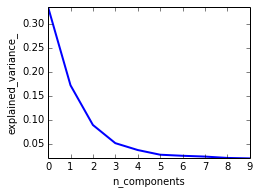

In [91]:
% pylab inline 

columns = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10"]
 
features = df_user_features[list(columns)].values

# Very few samples have complete data. Hence, we impute missing values to retain 
# all sample data, which will otherwise be lost during standardization
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X = imp.fit_transform(features)

# Preprocessing dataset and feature standardization to have normally distributed data
X = MaxAbsScaler().fit_transform(X)

# Decompose using PCA to study explained variance
pca = decomposition.PCA()

###############################################################################
# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

#### First 3 components explain approximately 75% of the variance

In [92]:
pca = decomposition.PCA(n_components=10)
X_pca = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


explained variance ratio (first two components): [ 0.42139016  0.21604524  0.11161602  0.06385404  0.04577466  0.03343983
  0.03063378  0.02854902  0.0249371   0.02376015]


Distinct predicted class labels (user groups):  set([0, 1, 2, 3, 4])


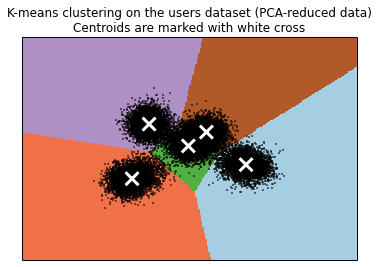

In [93]:
###############################################################################
# Visualize the results on PCA-reduced data (2 components)
# We have prior knowledge about number of clusters based on user groups (5 clusters)

reduced_data = decomposition.PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# print distinct predicted class labels
print "Distinct predicted class labels (user groups): ",
print set(Z)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the users dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

#### K-means and Agglomerative clustering techniques have been explored with reduced data using different number of PCA components (2, 3, 4). Best performance reported using K-means clustering with 3 components measured using silhoutte_score metric. Hence, I finally use K-means on reduced data with 3 PCA components for clustering users into one of the 5 groups (0, 1, 2, 3, 4) as part of Question 2 solution.

In [94]:
# Compute silhouette score for all sample points
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster, 
# as a different cluster is more similar.

# Clustering technique = k-means
# Run with different number of PCA components to find optimal number of components

print "K-means Clustering:"

n_comp_list = [2, 3, 4]
for n_components in n_comp_list:
    reduced_data = decomposition.PCA(n_components=n_components).fit_transform(X)
    kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # It gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print "The average silhouette_score for %d components is :" %n_components,
    print silhouette_avg

K-means Clustering:
The average silhouette_score for 2 components is : 0.551313723879
The average silhouette_score for 3 components is : 0.57588085465
The average silhouette_score for 4 components is : 0.5500869031


In [335]:
# Compute silhouette score for all sample points
# The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster, 
# as a different cluster is more similar.

# Clustering technique = Agglomerative Clustering
# Run with different number of PCA components to find optimal number of components

print "Agglomerative Clustering:"

n_comp_list = [2, 3, 4]
for n_components in n_comp_list:
    reduced_data = decomposition.PCA(n_components=n_components).fit_transform(X)
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(reduced_data, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    agglo = AgglomerativeClustering(n_clusters=5, linkage='ward', connectivity=connectivity)

    cluster_labels = agglo.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # It gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print "The average silhouette_score for %d components is :" %n_components,
    print silhouette_avg

Agglomerative Clustering:
The average silhouette_score for 2 components is : 0.538599011011
The average silhouette_score for 3 components is : 0.571878887359
The average silhouette_score for 4 components is : 0.54494835263


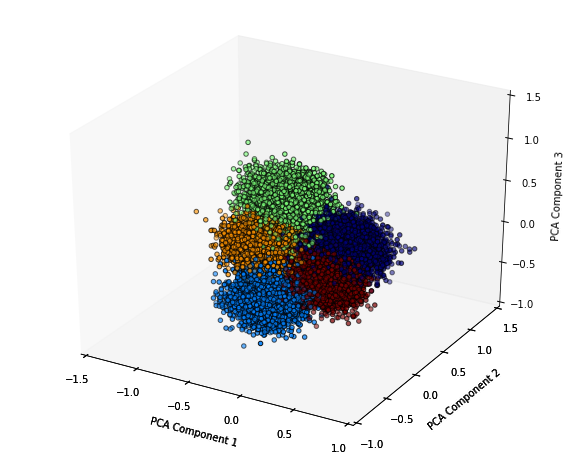

In [95]:
# 3D plot with n_components = 3 and k-means clustering (n_clusters = 5)

reduced_data = decomposition.PCA(n_components=3).fit_transform(X)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
cluster_labels = kmeans.fit_predict(reduced_data)

fig = plt.figure(figsize=(10, 8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
plt.cla()

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=cluster_labels.astype(np.float))

ax.grid(False)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

In [28]:
df_user_features['group.id'] = cluster_labels

In [29]:
# Check group assignments
df_user_features.head()

,user.id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,group.id
0,5341475c4efa972750f5e00f,0.207102,1.944413,-1.766458,0.307927,0.444600,1.458632,2.387130,-0.807973,NaN,2.435970,2
1,52715cdeb6a88e9514b4da29,-0.745313,-2.624524,-2.878580,1.573517,-1.590816,1.031755,-1.681597,2.949915,-0.089606,2.995953,4
2,52c3e99eb6a88e9514de886c,-1.146234,-1.356037,-1.150768,NaN,0.034469,0.761808,0.020032,3.056027,-2.076585,NaN,4
3,51c35f15217c626224a939c1,1.633602,3.656310,0.093640,-2.389029,2.922590,-0.925852,2.822358,1.101865,0.916030,-0.313666,3
4,52893675b6a88e9514c08801,0.122813,2.347392,-1.420693,-3.575840,NaN,-0.793511,1.777240,0.374216,0.233496,0.515208,3


In [96]:
# This function clusters users into one of the 5 groups (0, 1, 2, 3, 4)
# Based on these user group assignments, it computes the mean of total messages each group received
# Function returns the mean of the total number of messages each group has received since signing up on the client's website. 

def avg_message_count_by_group(df_users, df_messages, df_user_features):
    
    columns = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10"]
 
    features = df_user_features[list(columns)].values

    # Impute missing values to retain all sample data
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    X = imp.fit_transform(features)

    X = MaxAbsScaler().fit_transform(X)

    reduced_data = decomposition.PCA(n_components=3).fit_transform(X)
    kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_data)
    
    df_user_features['group.id'] = cluster_labels
    
    # Call utility function to join the two dataframes
    df_joined_users_messages = get_merged_dataframes(df_users, df_messages)
    df_joined_users_messages_features = get_merged_dataframes(df_user_features, df_joined_users_messages)
      
    # Only keep messages that were received since signing up
    df_joined_users_messages_features = df_joined_users_messages_features[df_joined_users_messages_features['message.date'] 
                                                                          >= df_joined_users_messages_features['signup.date']]
        
    # Get the average message count grouped by group.id
    avg_message_count = df_joined_users_messages_features.groupby('group.id')['message.count'].mean()
    
    # Return the average message count grouped by user groups and rounded to 2 decimals
    return np.round(avg_message_count.tolist(), decimals=2)
        
print "Question 2: ",
print avg_message_count_by_group(df_users, df_messages, df_user_features)

Question 2:  [ 1.67  1.68  1.67  1.68  1.68]


In [97]:
# Call utility function to join the two dataframes
df_joined_users_features = pd.merge(df_users, df_user_features, on='user.id')
df_joined_users_features.head(5)

,user.id,signup.date,response,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,group.id
0,5341475c4efa972750f5e00f,2014-04-06 00:00:00,1,0.207102,1.944413,-1.766458,0.307927,0.444600,1.458632,2.387130,-0.807973,NaN,2.435970,1
1,52715cdeb6a88e9514b4da29,2013-10-30 00:00:00,0,-0.745313,-2.624524,-2.878580,1.573517,-1.590816,1.031755,-1.681597,2.949915,-0.089606,2.995953,3
2,52c3e99eb6a88e9514de886c,2014-01-01 00:00:00,1,-1.146234,-1.356037,-1.150768,NaN,0.034469,0.761808,0.020032,3.056027,-2.076585,NaN,3
3,51c35f15217c626224a939c1,2013-06-20 00:00:00,1,1.633602,3.656310,0.093640,-2.389029,2.922590,-0.925852,2.822358,1.101865,0.916030,-0.313666,0
4,52893675b6a88e9514c08801,2013-11-17 00:00:00,0,0.122813,2.347392,-1.420693,-3.575840,NaN,-0.793511,1.777240,0.374216,0.233496,0.515208,0


### Question 3: Our client is interested in building a model that can predict the response variable (given in users.csv) for a user given its features. Write a function that takes as input the user features and outputs the predicted response variable. Recall from Question 2 that there are 5 different types of users that visit the client’s website. Report the predicted response for the three users in the test.csv file.

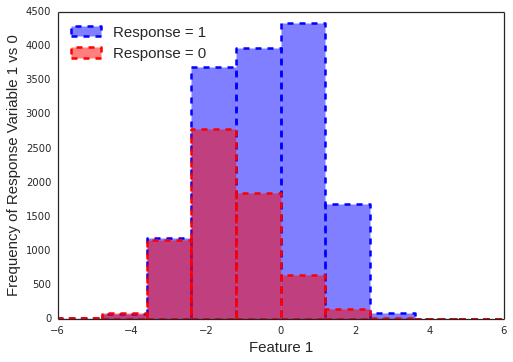

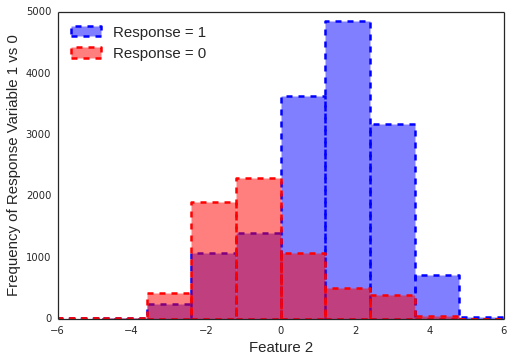

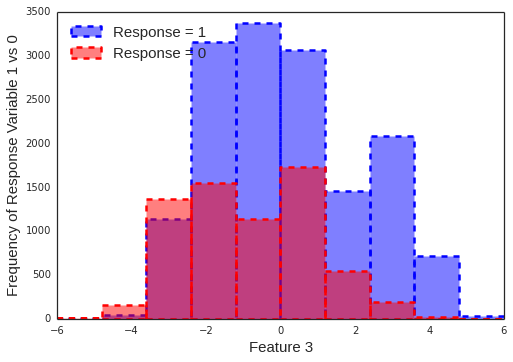

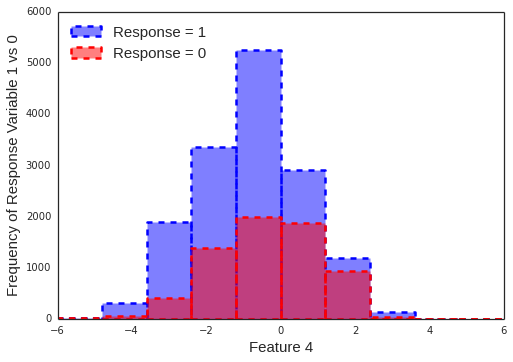

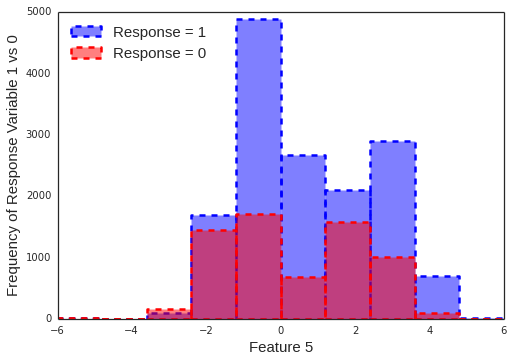

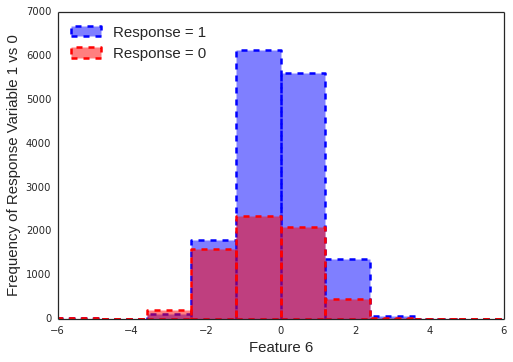

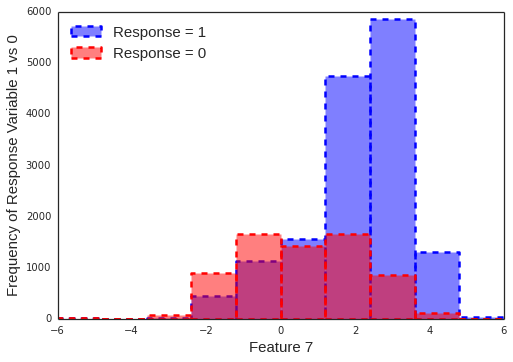

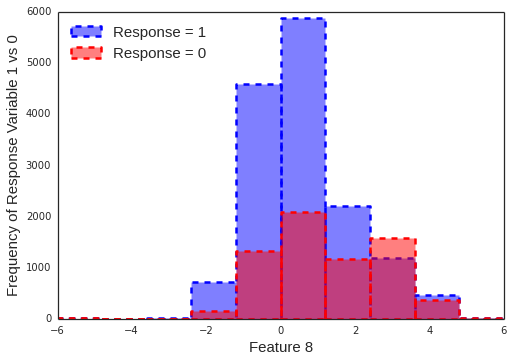

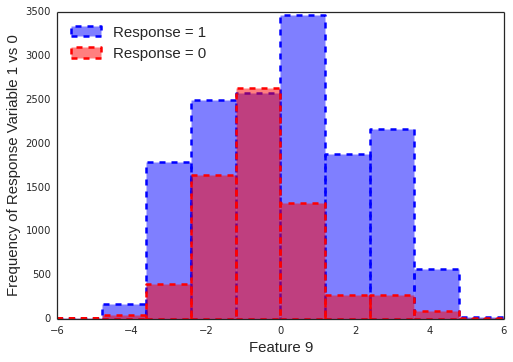

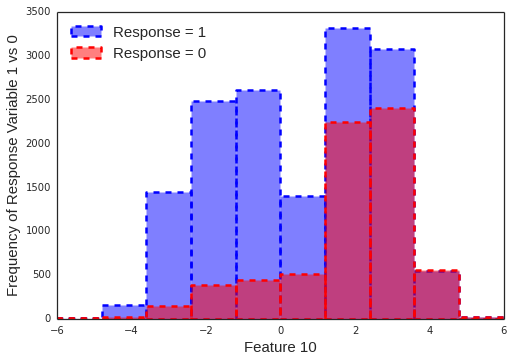

In [232]:
# Visualize response variable distributions by each feature

for i in range(1,11):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = df_joined_users_features['f%d' %i].values
    y = df_joined_users_features['response'].values

    ax.hist(x[y==1], color='blue', ls='dashed', bins=10, range=(-6,6), fc=(0,0,1,0.5), lw=2.5, 
             edgecolor='blue', label = 'Response = 1')
    ax.hist(x[y==0], color='red', ls='dashed', bins=10, range=(-6,6), fc=(1,0,0,0.5), lw=2.5, 
             edgecolor='red', label = 'Response = 0')
    ax.set_xlabel('Feature %d' %i, fontsize=15)
    ax.set_ylabel('Frequency of Response Variable 1 vs 0', fontsize=15)
    
    ax.legend = plt.legend(loc='upper left', prop={'size':15})

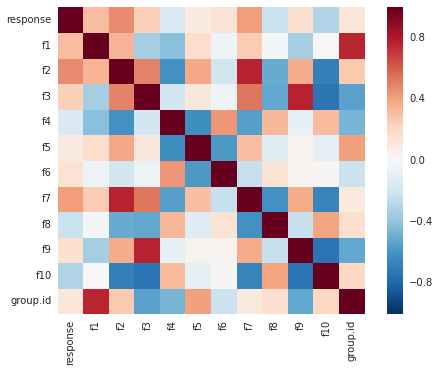

In [214]:
# Visualize correlation between user features, group and response
import seaborn as sns

cm = df_joined_users_features.loc[:].corr()
sns.heatmap(cm, square = True)

#### I used GridSearchCV to find what regularization to use with logistic regression classifier and also the regularization strength. Please note that I am not imputing missing values for Question 3 as it results in classifier performance drop. So, I only retain samples with complete data.

In [44]:
# finding the best model and parameter

y, X = dmatrices('response ~ f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10', 
                 df_joined_users_features, return_type="dataframe")

# Preprocessing dataset and feature standardization to have normally distributed data
X = MaxAbsScaler().fit_transform(X)

y = np.ravel(y)

# evaluate the model by splitting into train and test sets (70:30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# finding the best parameter for the logistic regression one versus rest
gs = GridSearchCV(
   estimator = LogisticRegression(random_state=0), 
   param_grid = {'penalty': ['l1','l2'],
       'C': [0.01, 0.1, 1, 10, 100]},
   scoring='roc_auc',
   cv=10, verbose = 1,
   n_jobs=-1)
   
gs = gs.fit(X_train, y_train)
print "{'Score': %.4f}" % gs.best_score_
print(gs.best_params_)
print("---------------------")

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'Score': 0.8896}
{'penalty': 'l1', 'C': 100}
---------------------


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


#### I studied classification summary scores with l1 and l2 regularization. They are similar, so I decided to use l2 regularization with strength 100. I chose l2, because it retains all features and we do not have the sparsity problem in this dataset. 

In [98]:
# Scores with L1 and L2 regularization

clf_l1_LR = LogisticRegression(C=100, penalty='l1', tol=0.01)
clf_l2_LR = LogisticRegression(C=100, penalty='l2', tol=0.01)
clf_l1_LR.fit(X_train, y_train)
clf_l2_LR.fit(X_train, y_train)

l1_predicted = clf_l1_LR.predict(X_test)
l2_predicted = clf_l2_LR.predict(X_test)

print "C=100, ",
print "Metrics classification summary with L1 penalty: "
print metrics.classification_report(y_test, l1_predicted)
print "C=100, ",
print "Metrics classification summary with L2 penalty: "
print metrics.classification_report(y_test, l2_predicted)

C=100,  Metrics classification summary with L1 penalty: 
             precision    recall  f1-score   support

        0.0       0.77      0.69      0.73       828
        1.0       0.87      0.90      0.89      1824

avg / total       0.84      0.84      0.84      2652

C=100,  Metrics classification summary with L2 penalty: 
             precision    recall  f1-score   support

        0.0       0.77      0.69      0.73       828
        1.0       0.87      0.90      0.88      1824

avg / total       0.83      0.84      0.84      2652



#### I finally used logistic regression classifier, however below are details of other classfiers I explored to see if any gave much better performance. 

In [46]:
# Comparing classifiers

# Train model using logistic regression
logreg = LogisticRegression(C=100, penalty='l2', tol=0.01)
logreg.fit(X_train, y_train)

# predict class labels for the test set
predicted = logreg.predict(X_test)

print "Classification Summary Using Logistic Regression:"
print metrics.classification_report(y_test, predicted)

# Train model using Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# predict class labels for the test set
predicted = gnb.predict(X_test)

print "Classification Summary Using Naive Bayes:"
print metrics.classification_report(y_test, predicted)

# Train model using Linear SVC
svc = LinearSVC()
svc.fit(X_train, y_train)

# predict class labels for the test set
predicted = svc.predict(X_test)

print "Classification Summary Using Linear Support Vector Classification:"
print metrics.classification_report(y_test, predicted)

# Train model using Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# predict class labels for the test set
predicted = rf.predict(X_test)

print "Classification Summary Using Random Forest:"
print metrics.classification_report(y_test, predicted)

Classification Summary Using Logistic Regression:
             precision    recall  f1-score   support

        0.0       0.77      0.69      0.73       828
        1.0       0.87      0.90      0.88      1824

avg / total       0.83      0.84      0.84      2652

Classification Summary Using Naive Bayes:
             precision    recall  f1-score   support

        0.0       0.63      0.73      0.68       828
        1.0       0.87      0.81      0.84      1824

avg / total       0.80      0.78      0.79      2652

Classification Summary Using Linear Support Vector Classification:
             precision    recall  f1-score   support

        0.0       0.76      0.69      0.73       828
        1.0       0.87      0.90      0.88      1824

avg / total       0.83      0.84      0.83      2652

Classification Summary Using Random Forest:
             precision    recall  f1-score   support

        0.0       0.77      0.74      0.76       828
        1.0       0.89      0.90      0.89   

#### Random forest gives slightly better performance than logistic regression classifier. However, logistic regression classifier is faster and more interpretable, so I finally use this.

In [47]:
# Comparing classifier running time

start = time.time()
clf = LogisticRegression(C=100, penalty='l2', tol=0.01)
clf.fit(X, y)
end = time.time()
scores = cross_val_score(LogisticRegression(C=100, penalty='l2', tol=0.01), X, y, scoring='roc_auc', cv=10)
print "Logistic Regression: "
print "Total Running Time: ", end - start
print "Mean ROC AUC score with 10 fold CV: ", scores.mean()
scores = cross_val_score(LogisticRegression(C=10, penalty='l2', tol=0.01), X, y, scoring='f1', cv=10)
print "Mean f1 score with 10 fold CV: ", scores.mean()
print "\n"

start = time.time()
clf = GaussianNB()
clf.fit(X, y)
end = time.time()
scores = cross_val_score(GaussianNB(), X, y, scoring='roc_auc', cv=10)
print "Naive Bayes: "
print "Total Running Time: ", end - start
print "Mean ROC AUC score with 10 fold CV: ", scores.mean()
scores = cross_val_score(GaussianNB(), X, y, scoring='f1', cv=10)
print "Mean f1 score with 10 fold CV: ", scores.mean()
print "\n"

start = time.time()
clf = LinearSVC(C=1.0)
clf.fit(X, y)
end = time.time()
scores = cross_val_score(LinearSVC(C=1.0), X, y, scoring='roc_auc', cv=10)
print "Support Vector Classification: "
print "Total Running Time: ", end - start
print "Mean ROC AUC score with 10 fold CV: ", scores.mean()
scores = cross_val_score(LinearSVC(C=1.0), X, y, scoring='f1', cv=10)
print "Mean f1 score with 10 fold CV: ", scores.mean()
print "\n"

start = time.time()
clf = RandomForestClassifier()
clf.fit(X, y)
end = time.time()
scores = cross_val_score(RandomForestClassifier(), X, y, scoring='roc_auc', cv=10)
print "Random Forest Classification: "
print "Total Running Time: ", end - start
print "Mean ROC AUC score with 10 fold CV: ", scores.mean()
scores = cross_val_score(RandomForestClassifier(), X, y, scoring='f1', cv=10)
print "Mean f1 score with 10 fold CV: ", scores.mean()
print "\n"

Logistic Regression: 
Total Running Time:  0.0170469284058
Mean ROC AUC score with 10 fold CV:  0.891705612031
Mean f1 score with 10 fold CV:  0.886047024534


Naive Bayes: 
Total Running Time:  0.0032970905304
Mean ROC AUC score with 10 fold CV:  0.801401110306
Mean f1 score with 10 fold CV:  0.834564877081


Support Vector Classification: 
Total Running Time:  0.0499758720398
Mean ROC AUC score with 10 fold CV:  0.891409230359
Mean f1 score with 10 fold CV:  0.885721981178


Random Forest Classification: 
Total Running Time:  0.172307014465
Mean ROC AUC score with 10 fold CV:  0.915211381092
Mean f1 score with 10 fold CV:  0.897398983527




#### Note than logistic regression and random forest predict identical user responses for the test dataset. However, accompanying python code only uses logistic regression as it is faster and is therefore preferred over random forest to solve question 3.

In [66]:
def predict_user_response(df_users, df_user_features, df_test):
    
    # Perform outer join on users and user_features dataframes to combine user's response 
    # with features specific to each user
    df_joined_users_messages = pd.merge(df_users, df_user_features, on='user.id')
    
    # Filter out rows that contain null values in any of the columns listed below:
    # 'user.id', 'response'
    df_joined_users_features = df_joined_users_messages.dropna(subset=['user.id','response'], how='any')
    
    y, X = dmatrices('response ~ f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10', 
    df_joined_users_features, return_type="dataframe")
    
    y = np.ravel(y)
    
    # Split into train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Train models using the train dataset, which is 80% of the original dataset
    clf1 = RandomForestClassifier()
    clf1.fit(X_train, y_train) 
  
    clf2 = LogisticRegression(C=100, penalty='l2', tol=0.01)
    clf2.fit(X_train, y_train)
        
    # Test the trained model on a brand new test set
    df_test = df_test.fillna(df_test.mean())
    
    X_test = dmatrix('f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10', 
                     df_test, return_type="dataframe")

    X_test = MaxAbsScaler().fit_transform(X_test)
          
    predicted_response1 = clf1.predict(X_test)
    
    print "Random Forest Classification: ",
    print [int(response) for response in predicted_response1]
    
    predicted_response2 = clf2.predict(X_test)
    
    print "Logistic Regression: ",
    print [int(response) for response in predicted_response2]
    
    print "Question 3: ",
    print [int(response) for response in predicted_response2]

predict_user_response(df_users, df_user_features, df_test)

Random Forest Classification:  [1, 1, 1]
Logistic Regression:  [1, 1, 1]
Question 3:  [1, 1, 1]


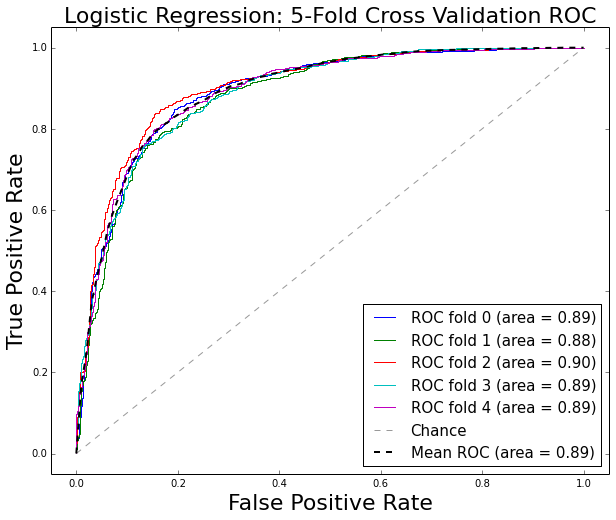

In [65]:
# Plotting ROC AUC

logreg = LogisticRegression(C=100, penalty='l2', tol=0.01)

# Run classifier with cross-validation and plot ROC curves
cv = KFold(len(y), n_folds=5)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

plt.figure(figsize=(10,8))

for i, (train, test) in enumerate(cv):
    probas_ = logreg.fit(X[train[0]:train[-1]], y[train[0]:train[-1]]).predict_proba(X[test[0]:test[-1]])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test[0]:test[-1]], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('Logistic Regression: 5-Fold Cross Validation ROC', fontsize=22)
plt.legend(loc="lower right", prop={'size':15})
plt.show()